In [2]:
#import modules
import os
import time
from typing import Callable, Dict, List, Optional, Tuple, Union
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import mars_troughs as mt
import emcee, corner
from importlib import reload
from mars_troughs import DATAPATHS, Model
from mars_troughs.datapaths import (
    load_insolation_data,
    load_obliquity_data,
    load_retreat_data)

In [3]:
#Load data
xdata,ydata=np.loadtxt(DATAPATHS.TMP, unpack=True) #Observed TMP data
xdata=xdata*1000 #km to m 
(ins,times) = load_insolation_data() #Insolation data and times
times=-times

In [4]:
#Define parameters MCMC and initial values 
maxSteps=100
subIter=10

#Define accu and lag parameters
acc_test_params = [1e-4, 1e-6]
acc_model_name = "obliquity"
lag_test_params = [7, 1e-6]
lag_model_name = "linear"
errorbar = np.sqrt(1.6) #errorbar in pixels on the datapoints
angle= 5.0

In [5]:
#Create trough object
tr = mt.Trough(acc_model_name,lag_model_name,acc_test_params,lag_test_params,
                errorbar,angle)

In [6]:
tr.all_parameters

{'errorbar': 1.2649110640673518,
 'acc_intercept': 0.0001,
 'acc_slope': 1e-06,
 'lag_intercept': 7,
 'lag_slope': 1e-06}

loglike= -1663.3015173482813


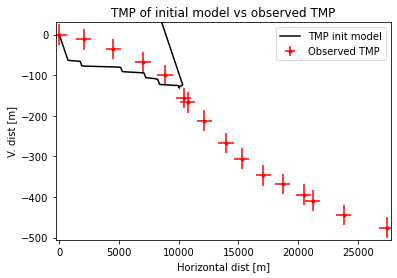

In [7]:
#Compare the trajectory of the initial model with the data
xInit,yInit=tr.get_trajectory(times)
plt.plot(xInit, yInit, c='k',label='TMP init model')
xerr, yerr = tr.errorbar*tr.meters_per_pixel
plt.errorbar(x=xdata, xerr=xerr, y=ydata, yerr=yerr, c='r', marker='.', ls='',label='Observed TMP')
xlim = [np.min(xdata)-300, np.max(xdata)+300] #meters
ylim = [np.min(ydata)-30, 30]
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Horizontal dist [m]")
plt.ylabel("V. dist [m]")
plt.title("TMP of initial model vs observed TMP")
ax=plt.gca()
ax.legend()
print("loglike=", tr.lnlikelihood(xdata,ydata))

In [8]:
#Find number of dimensions and number of parameters per submodel
npar_acc=len(tr.accuModel.parameters)
npar_lag=len(tr.lagModel.parameters)
ndim=npar_acc+npar_lag+1
nwalkers=ndim*4

In [9]:
#Define the log likelihood
def ln_likelihood(params: Dict[str,float]):
    
    errorbar: float = params["errorbar"]
    
    if errorbar < 0: #prior on the variance (i.e. the error bars)
        return -1e99

    tr.set_model(params)
    
    lag_t=tr.lagModel.get_lag_at_t(times)

    if any(lag_t < 0) or any(lag_t > 20):

        return -1e99

    return tr.lnlikelihood(xdata,ydata)

#And the negative of the log likelihood
def neg_ln_likelihood(paramsArray):
    
    parameter_names = ([key for key in tr.all_parameters])
    params=dict(zip(parameter_names, paramsArray))
    
    return -ln_likelihood(params)


In [10]:
#Linear optimization
guess=np.array([errorbar]+acc_test_params+lag_test_params)
optObj= op.minimize(neg_ln_likelihood, x0=guess, method='Nelder-Mead')
optParams=optObj['x']
optParams

array([ 3.09844116e+00,  1.59802570e-04, -4.86447523e-09,  6.10035305e+00,
        1.05462366e-06])

loglike= -196.17934818148032


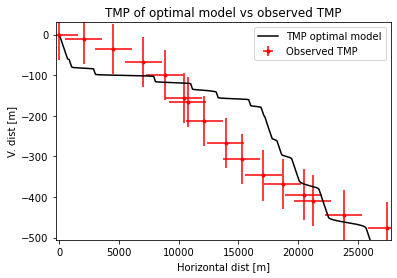

In [11]:
#Compare the trajectory of the optimal model with the data
parameter_names = ([key for key in tr.all_parameters])
optParamsDict=dict(zip(parameter_names, optParams))

tr.set_model(optParamsDict)

xOpt,yOpt=tr.get_trajectory(times)

plt.plot(xOpt, yOpt, c='k',label='TMP optimal model')
xerr, yerr = tr.errorbar*tr.meters_per_pixel
plt.errorbar(x=xdata, xerr=xerr, y=ydata, yerr=yerr, c='r', marker='.', ls='',label='Observed TMP')
xlim = [np.min(xdata)-300, np.max(xdata)+300] #meters
ylim = [np.min(ydata)-30, 30]
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Horizontal dist [m]")
plt.ylabel("V. dist [m]")
plt.title("TMP of optimal model vs observed TMP")
ax=plt.gca()
ax.legend()
print("loglike=", tr.lnlikelihood(xdata,ydata))

In [27]:
#Set directory to save ensemble and figures
directory='../../outputMCMC/'
if not os.path.exists(directory):
            os.makedirs(directory)
subdir='acc_'+acc_model_name+'_lag_'+lag_model_name+'/'
if not os.path.exists(directory+subdir):
            os.makedirs(directory+subdir)


In [32]:
#Set file to save progress 
filename=directory+subdir+str(maxSteps)
backend=emcee.backends.HDFBackend(filename+'.h5')
backend.reset(nwalkers,ndim)

#Set optimized parameter values as initial values of MCMC chains 
params=np.array([optParams+ 1e-3*optParams*np.random.randn(ndim) for i in range(nwalkers)])
parameter_names = ([key for key in tr.all_parameters])


In [33]:
start = time.time()
#Initialize sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_likelihood, 
                                backend=backend, parameter_names=parameter_names)
#Run MCMC and track progress
sampler.reset()
#Iteratively compute autocorrelation time Tau
index=0
autocorr=np.zeros(int(maxSteps/subIter))
old_tau=np.inf

#compute tau every subIter iterations
for sample in sampler.sample(params,iterations=maxSteps, progress=True):

    if sampler.iteration%subIter:
        continue
        
    tau=sampler.get_autocorr_time(tol=0)
    autocorr[index]=np.mean(tau)
    index+=1
    converged=np.all(tau*50<sampler.iteration)
    converged&=np.all(np.abs(old_tau-tau)/tau<0.01)
    
    if converged:
        break
    
    old_tau=tau
    
end = time.time()
running_time=end-start
print("MCMC running time {0:.1f} seconds".format(running_time))


100%|██████████| 100/100 [00:14<00:00,  6.84it/s]

MCMC running time 14.8 seconds


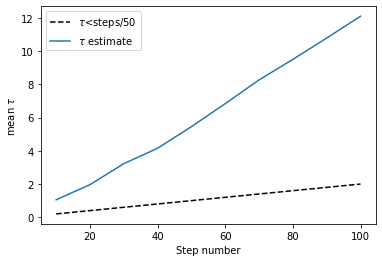

In [34]:
#Plot autocorrelation time estimates
steps=subIter*np.arange(1,index+1)
plt.plot(steps,steps/50,"--k",label=r'$\tau$<steps/50 ')
plt.plot(steps,autocorr[np.nonzero(autocorr)],label=r'$\tau$ estimate')
plt.xlabel('Step number')
plt.ylabel(r'mean $\tau$')
ax=plt.gca()
ax.legend()
plt.savefig(filename+'_autocorr'+'.pdf',facecolor='w',pad_inches=0.1)

In [35]:
#Save posterior and model parameters during burn in----------------------------------

#save values of parameters during burn in
posteriorOut=sampler.get_log_prob()
posteriorOut=posteriorOut.T
errorOut=sampler.chain[:,:,0]
accIntOut=sampler.chain[:,:,1]
accSlopeOut=sampler.chain[:,:,2]
lagIntOut=sampler.chain[:,:,3]
lagSlopeOut=sampler.chain[:,:,4]


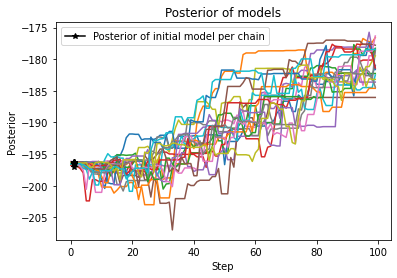

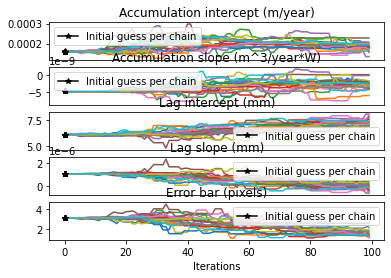

In [36]:
#plot posterior of models for all chains. 
#Values from different lines come from different chains
plt.figure()
plt.plot(posteriorOut.T)
plt.plot(np.ones(nwalkers),posteriorOut.T[1],marker='*',c='k',label='Posterior of initial model per chain')
plt.xlabel('Step')
plt.ylabel('Posterior')
plt.title('Posterior of models')
ax=plt.gca()
ax.legend()
plt.savefig(filename+'_posterior'+'.pdf',facecolor='w',pad_inches=0.1)
#plot value of parameters of models per chain. 
#Values from different lines come from different chains

fig=plt.figure()
plt.tight_layout

plt.subplot(5,1,1)
for i in range(nwalkers):
    plt.plot(accIntOut[i,:])
    pi=params[i]
    plt.plot(pi[1],marker='*',c='k')
plt.plot(pi[1],marker='*',c='k',label='Initial guess per chain')
plt.xticks([], [])
plt.title('Accumulation intercept (m/year)')
ax=plt.gca()
ax.legend()

plt.subplot(5,1,2)
for i in range(nwalkers):
    plt.plot(accSlopeOut[i,:])
    pi=params[i]
    plt.plot(pi[2],marker='*',c='k')
plt.plot(pi[2],marker='*',c='k',label='Initial guess per chain')
plt.xticks([], [])
plt.title('Accumulation slope (m^3/year*W)')
ax=plt.gca()
ax.legend()

plt.subplot(5,1,3)
for i in range(nwalkers):
    plt.plot(lagIntOut[i,:])
    pi=params[i]
    plt.plot(pi[3],marker='*',c='k')
plt.plot(pi[3],marker='*',c='k',label='Initial guess per chain')
plt.xticks([], [])
plt.title('Lag intercept (mm)')
ax=plt.gca()
ax.legend()

plt.subplot(5,1,4)
for i in range(nwalkers):
    plt.plot(lagSlopeOut[i,:])
    pi=params[i]
    plt.plot(pi[4],marker='*',c='k')
plt.plot(pi[4],marker='*',c='k',label='Initial guess per chain')
plt.xticks([], [])
plt.title('Lag slope (mm)')
ax=plt.gca()
ax.legend()

plt.subplot(5,1,5)
for i in range(nwalkers):
    plt.plot(errorOut[i,:])
    pi=params[i]
    plt.plot(pi[0],marker='*',c='k')
plt.plot(pi[0],marker='*',c='k',label='Initial guess per chain')
plt.xlabel('Iterations')
plt.title('Error bar (pixels)')
ax=plt.gca()
ax.legend()
plt.savefig(filename+'_paramsIter'+'.pdf',facecolor='w',pad_inches=0.1)

In [37]:
#remove burn in and reshape for corner plot 
burnin=int(2 * np.max(autocorr))

posteriorEnsemble=np.reshape(posteriorOut[:,burnin:],(nwalkers*(np.max(steps)-burnin),))
accIntEnsemble=np.reshape(accIntOut[:,burnin:],(nwalkers*(np.max(steps)-burnin),))
accSlopeEnsemble=np.reshape(accSlopeOut[:,burnin:],(nwalkers*(np.max(steps)-burnin),))
lagIntEnsemble=np.reshape(lagIntOut[:,burnin:],(nwalkers*(np.max(steps)-burnin),))
lagSlopeEnsemble=np.reshape(lagSlopeOut[:,burnin:],(nwalkers*(np.max(steps)-burnin),))
errorEnsemble=np.reshape(errorOut[:,burnin:],(nwalkers*(np.max(steps)-burnin),))

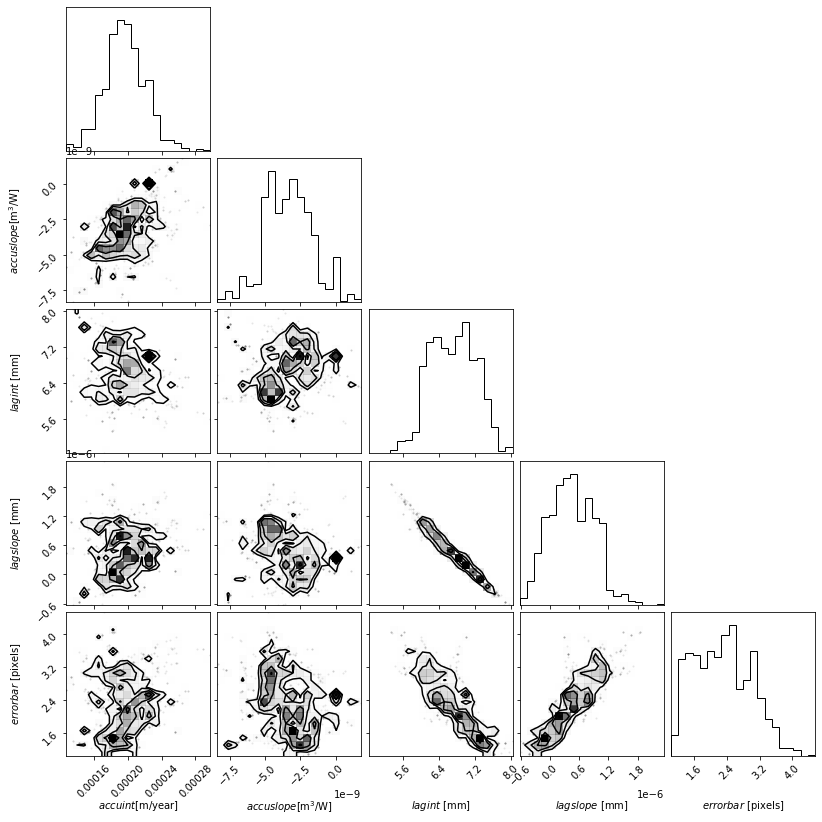

In [38]:
auxFig=np.array([accIntEnsemble,accSlopeEnsemble,lagIntEnsemble,lagSlopeEnsemble,errorEnsemble]).T
fig = corner.corner(auxFig, labels=[r"$accu int [{\rm m}/{\rm year}]$",
                                    r"$accu slope [{\rm m}^3/{\rm W}]$",
                                    r"$lag int \ [{\rm mm}]$",
                                    r"$lag slope\ [{\rm mm}]$",
                                    r"$errorbar\ [{\rm pixels}]$"])
plt.savefig(filename+'_cornerplot'+'.pdf',facecolor='w',pad_inches=0.1)

[1.5298133527423685, 0.00016424041219006391, -3.015646932567952e-09, 7.562638988653194, -2.7297907013456115e-07]
loglike= -175.7312180982722


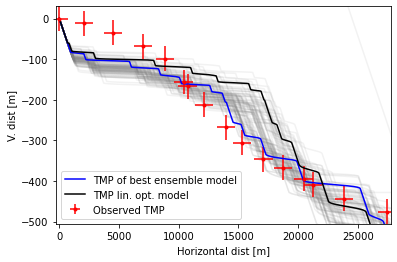

In [39]:
#plot ensemble TMP
numModels=len(posteriorEnsemble)
bestIndx=np.argmax(posteriorEnsemble)
optParamsMCMC=[errorEnsemble[bestIndx],
               accIntEnsemble[bestIndx],accSlopeEnsemble[bestIndx],
               lagIntEnsemble[bestIndx],lagSlopeEnsemble[bestIndx]]
print(optParamsMCMC)
tr.set_model(dict(zip(parameter_names, optParamsMCMC)))
xOptMCMC,yOptMCMC=tr.get_trajectory(times)
plt.plot(xOptMCMC, yOptMCMC, c='b',label='TMP of best ensemble model')
plt.plot(xOpt, yOpt, c='k',label='TMP lin. opt. model')
xerr, yerr = tr.errorbar*tr.meters_per_pixel
plt.errorbar(x=xdata, xerr=xerr, y=ydata, yerr=yerr, c='r', marker='.', ls='',label='Observed TMP')
print("loglike=", tr.lnlikelihood(xdata,ydata))
for i in range(100):
    modelIndx=np.random.randint(0,numModels)
    iparams=[errorEnsemble[modelIndx],
               accIntEnsemble[modelIndx],accSlopeEnsemble[modelIndx],
               lagIntEnsemble[modelIndx],lagSlopeEnsemble[modelIndx]]
    tr.set_model(dict(zip(parameter_names, iparams)))
    xi,yi=tr.get_trajectory(times)
    plt.plot(xi, yi, c="gray", alpha=0.1, zorder=-1)
plt.xlabel("Horizontal dist [m]")
plt.ylabel("V. dist [m]")
plt.xlim(xlim)
plt.ylim(ylim)
ax=plt.gca()
ax.legend()
plt.savefig(filename+'_TMPfit'+'.pdf',facecolor='w',pad_inches=0.1)